In [1]:
import napari
import napari_stress
import napari_process_points_and_surfaces as nppas
import vedo
import tqdm

from skimage import io, filters
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create viewer
viewer = napari.Viewer(ndisplay=3)

In [3]:
directory = r'C:\Users\johamuel\Documents\BiAPoL\Shared\BiAPoLprojects\20_STRESS\1_first_data'
raw = io.imread(os.path.join(directory, 'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps.tif'))
n_frames = raw.shape[0]

In [4]:
# Config
vsz = 3.998
vsy = 2.076
vsx = 2.076

surface_density = 0.1
curvature_radius = 10

In [5]:
viewer.add_image(raw, scale=[vsz, vsy, vsx], name='Raw data')

<Image layer 'Raw data' at 0x260407ed400>

## Preprocess

We first resample the image to isotropic voxel size and create a binary mask

In [6]:
# Resample
resampled_image = []
for t in range(n_frames):
    resampled_image.append(napari_stress.resample(raw[t], vsz=vsz, vsy=vsy, vsx=vsx))
resampled_image = np.asarray(resampled_image)
viewer.add_image(resampled_image, scale = 3 * [np.min([vsz, vsy, vsx])])

<Image layer 'resampled_image' at 0x2604ab94580>

In [7]:
# Masking
binary_image = resampled_image > filters.threshold_otsu(resampled_image)
binary_image_layer = viewer.add_labels(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])

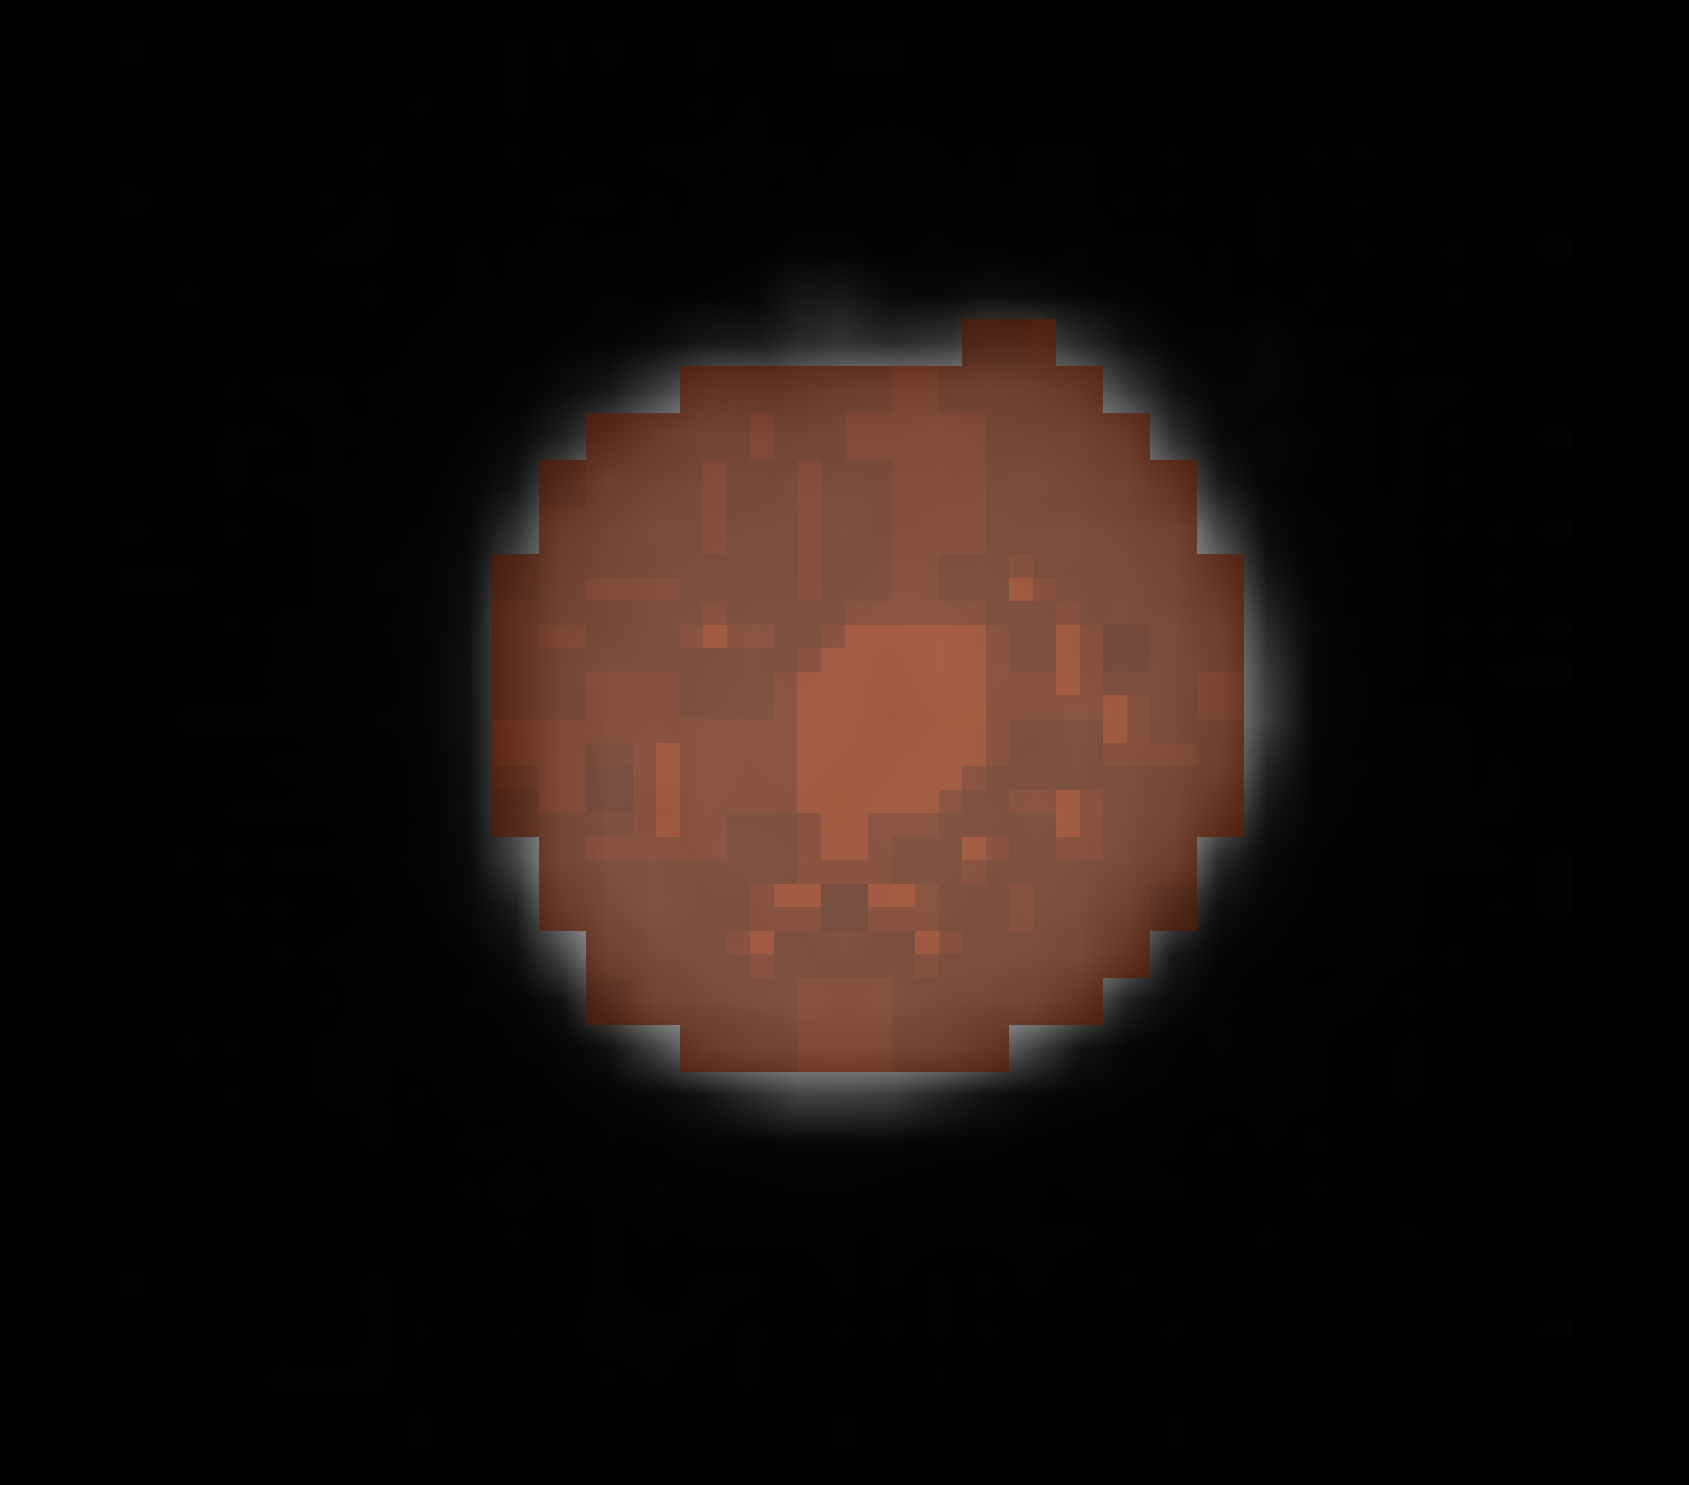

In [8]:
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Create surface

We use the marching cubes algorithm to create a surface from the binary image. We then smooth the surface a bit.

In [9]:
# Create surface
surface = napari_stress.surface_from_label(binary_image, scale = 3 * [np.min([vsz, vsy, vsx])])
surface_layer = viewer.add_surface(napari_stress.list_of_surfaces_to_surface(surface))

In [10]:
# Smooth surface
smoothed_surfaces = []
for t in range(n_frames):
    _smoothed_surf = nppas.filter_smooth_laplacian((surface[t].points(), surface[t].faces()), number_of_iterations=3)
    _smoothed_surf = napari_stress.smooth_sinc(_smoothed_surf, niter=30)
    smoothed_surfaces.append(_smoothed_surf)

smoothed_surface_layer = viewer.add_surface(napari_stress.list_of_surfaces_to_surface(smoothed_surfaces), name='Smoothed surface')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


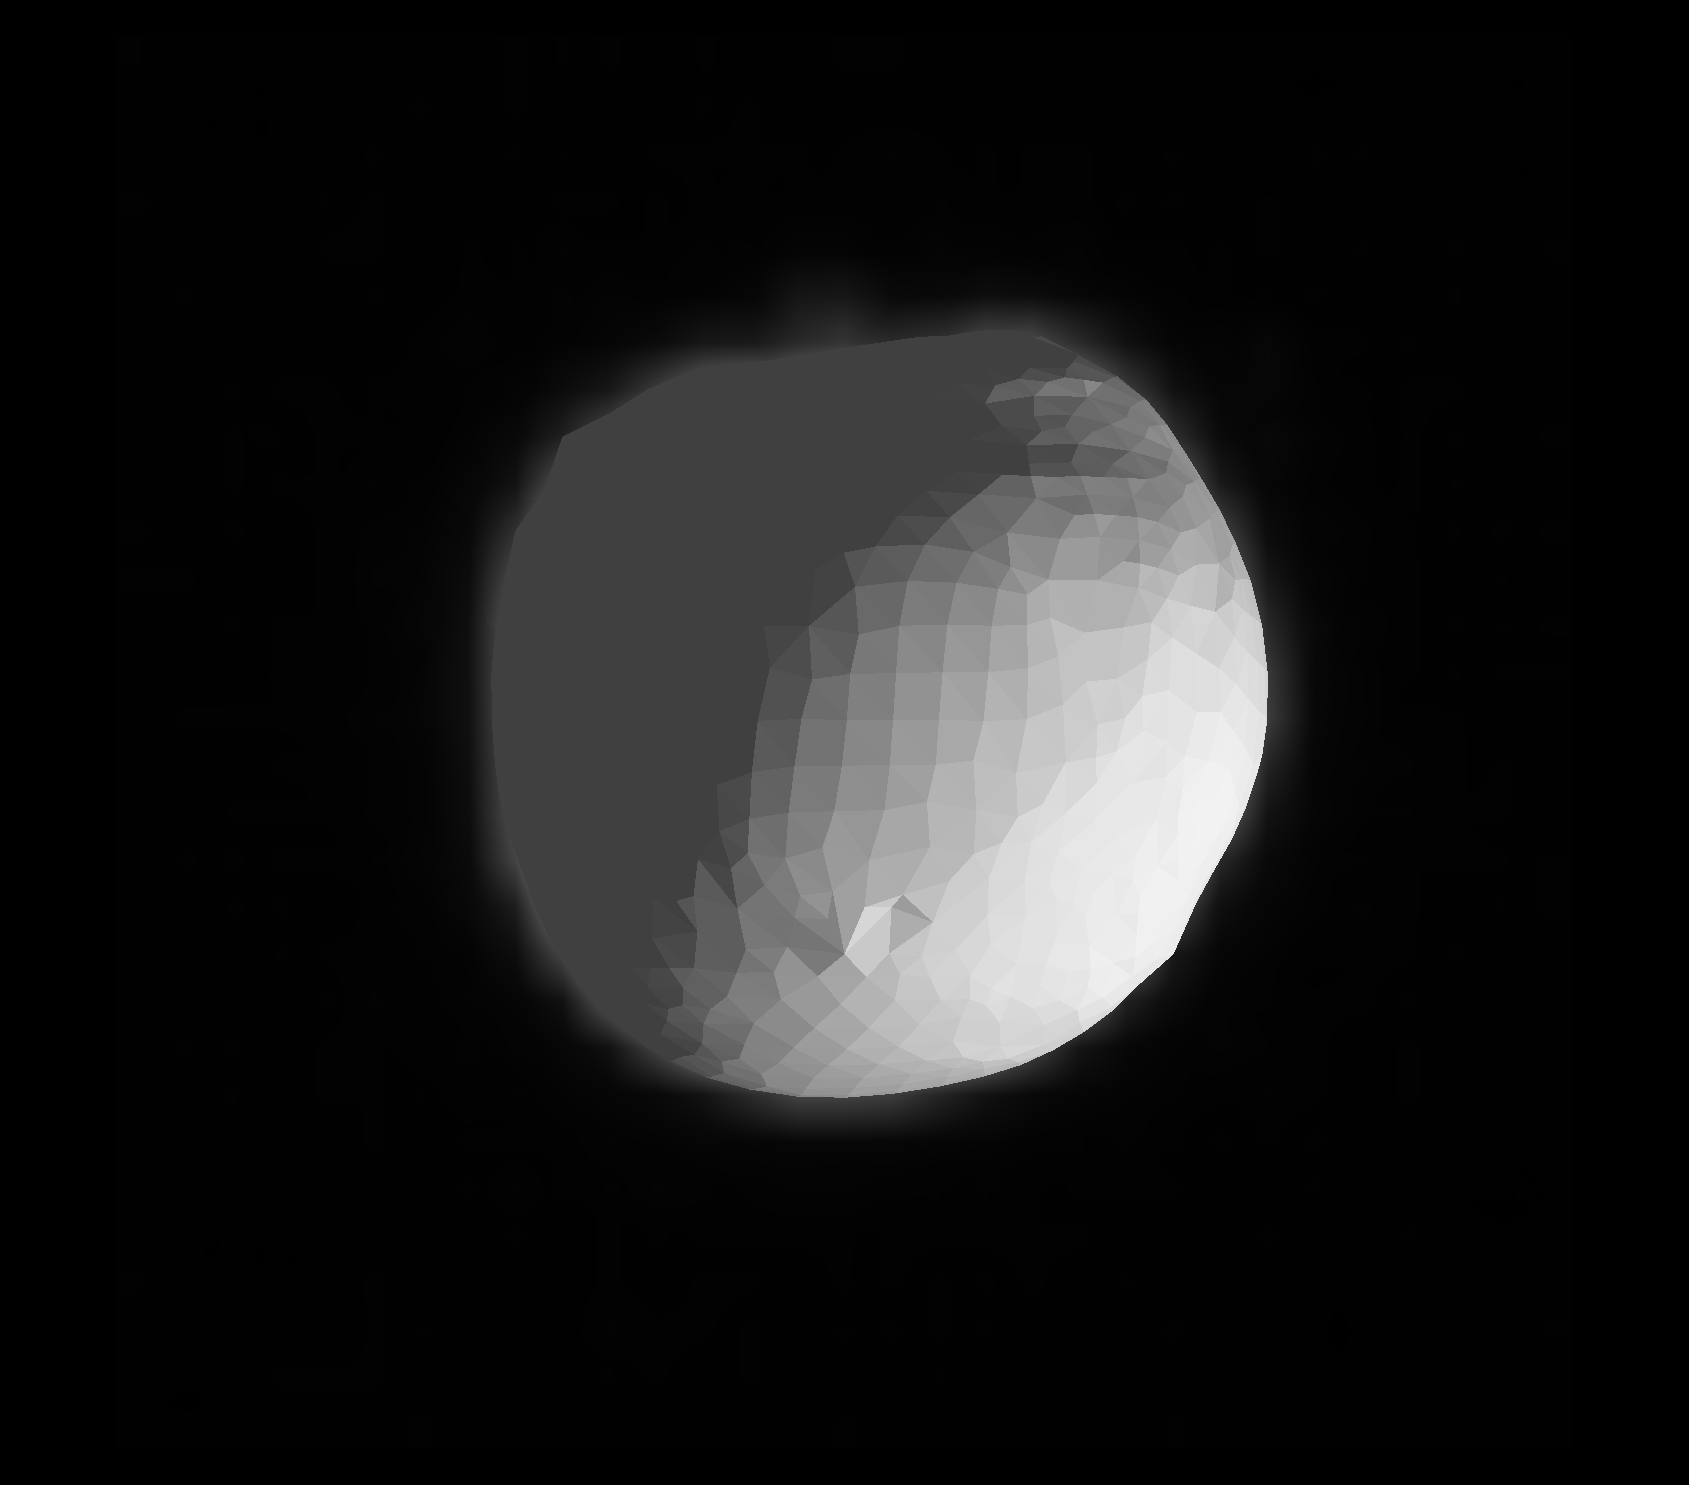

In [11]:
binary_image_layer.visible = False
surface_layer.visible = False
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Surface refinement

In the next step, we will trace-refine the surface, filter the detected points and resample the density of the vertices on the surface to a defined value. In detail:

* Resampling: If the numbers of vertices is above the required number of points for a given surface density, then the surface mesh is decimated to achieve the desired vertex density. If the mesh contains less points than desired, the mesh is interpolated and decimated again, if necessary.
* Trace refinement: Rays are cast along the surface normals at every point. A selected edge detection method is then used to detect the surface of the droplet
* Filtering: The edge-detection method returns an error. Points with fit errors above Q75 + 1.5 x IQR (Q75: 75% percentile, ICQ: inter-quartil range) are classified as outliers and removed from the list of points
* Surface reconstruction: Lastly, we recreate a surface from the remaining points and resample the existing points on the surface to fill possible holes.

In [12]:
# Surface resampling
density_adjusted_surfaces = []
for t in range(n_frames):
    density_adjusted_surfaces.append(napari_stress.adjust_surface_density(smoothed_surfaces[t], surface_density))
viewer.add_surface(napari_stress.list_of_surfaces_to_surface(density_adjusted_surfaces), name='density-adjusted surface')
viewer.add_points(napari_stress.list_of_surfaces_to_surface(density_adjusted_surfaces)[0], size=0.2)

<Points layer 'Points' at 0x2604bd22a00>

In [13]:
print('Number of vertices before adjustment:', smoothed_surfaces[t][0].shape[0])
print('Number of vertices after adjustment:', density_adjusted_surfaces[t][0].shape[0])

Number of vertices before adjustment: 1238
Number of vertices after adjustment: 375


In [14]:
# Trace refinement
traced_points = []
for t in tqdm.tqdm(range(n_frames)):
    vertices = smoothed_surfaces[t][0]
    faces = smoothed_surfaces[t][1]
    result = napari_stress.trace_refinement_of_surface(resampled_image[t], (vertices, faces),
                                                      trace_length=10.0, sampling_distance=0.1,
                                                      scale=binary_image_layer.scale[1:],
                                                      show_progress=False,
                                                      selected_fit_type='fancy',
                                                      remove_outliers=True,
                                                      interquartile_factor=3.0)
    
    pts4d = np.insert(np.stack(result['surface_points'].to_numpy()), 0, np.repeat(t, len(result)), axis=1)
    vec4d = np.insert(np.stack(result['projection_vector'].to_numpy()), 0, np.repeat(t, len(result)), axis=1)
    result['surface_points'] = list(pts4d)
    result['projection_vector'] = list(vec4d)
    traced_points.append(result)
    
    
_traced_points = pd.concat(traced_points, ignore_index=True).dropna()

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]C:\Users\johamuel\Anaconda3\envs\napari-test\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  5%|███▉                                                                               | 1/21 [00:07<02:28,  7.43s/it]C:\Users\johamuel\Anaconda3\envs\napari-test\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 10%|███████▉                                                                           | 2/21 [00:14<02:21,  7.44s/it]C:\Users\johamuel\Anaconda3\envs\napari-test\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated


In [15]:
smoothed_surface_layer.visible = False
points = np.stack(_traced_points['surface_points'].to_numpy())
vectors = np.stack(_traced_points['projection_vector'].to_numpy())
traced_points_layer = viewer.add_points(points, size=1, face_color='orange', name='fancy_trace_refined_points', edge_width=0.1)
trace_vector_layer = viewer.add_vectors(np.stack([points, vectors]).transpose((1,0,2)), edge_width=0.2, name='trace_vectors')

napari.utils.nbscreenshot(viewer, canvas_only=True)
trace_vector_layer.visible = False

In [16]:
# Retrieve points from results
points = napari_stress.points_to_list_of_points(np.stack(_traced_points['surface_points'].to_numpy()))

In [17]:
# Surface reconstruction
resampled_surfaces = []
for t in range(n_frames):
    
    _points = napari_stress.smoothMLS2D(points[t], radius=5.0)  # This removes bad points
    _surf = napari_stress.reconstruct_surface(_points)
    resampled_surfaces.append(_surf)

AttributeError: 'Points' object has no attribute 'reconstruct_Surface'

In [ ]:
trace_fitted_surface_layer = viewer.add_surface(
    napari_stress.list_of_surfaces_to_surface(resampled_surfaces),
    name='Trace-fitted surface')
napari.utils.nbscreenshot(viewer, canvas_only=True)

# Curvature

Lastly, we measure the curvature of the object:

In [ ]:
surfaces_with_curvatures = []
for t in range(n_frames):
    surfaces_with_curvatures.append(nppas.add_spherefitted_curvature(resampled_surfaces[t], radius=curvature_radius))

In [ ]:
surface_with_curvature = [surf[0][0] for surf in surfaces_with_curvatures]

In [ ]:
output = list(napari_stress.list_of_surfaces_to_surface(surface_with_curvature))

In [ ]:
output[2] = np.concatenate(output[2])

In [ ]:
viewer.add_surface((output[0], output[1], output[2]))